# Объединение моделей сегментции и OCR в единый пайплайн

В данном ноутбуке представлен baseline для пайплайна сегментации и OCR для чтения школьных тетрадей. Сегментация реализована с помощью фреймворка detectron2, OCR - с помощью модели CRNN.

Мы представляем подход, как объединить две модели сегментации и распознавания в одну систему, чтобы делать предсказание на целой странице тетради. В этом бейзлайне нет обучения. Мы используем модели, которые были обучены в бейзлайнах 1 и 2 этапов олимпиады. Участники могут использовать представленные нами ранее бейзлайны, переобучить модели на новых данных, и использовать их веса для текущего этапа.

### Установка библиотек

Установка библиотек, под которым запускается данный бейзлайн.

In [2]:
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!python -m pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html
!pip install tensorflow==2.1.0
!pip install opencv-python shapely==1.8.0

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html
  Using cached Shapely-1.8.0-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.1 MB)


### Загрузим необходимые библиотеки для создания модели

In [1]:
import cv2
import random
from PIL import ImageFont, ImageDraw, Image
import json
import os
from tqdm import tqdm
from shapely.geometry import Polygon
from matplotlib import pyplot as plt
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import shutil

import torch, torchvision
import torch.nn as nn
import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog,DatasetCatalog
from detectron2.data.datasets import register_coco_instances,load_coco_json
from detectron2.data import detection_utils as utils
from detectron2.engine import DefaultTrainer
from detectron2.engine import HookBase

# from detectron2.utils.logger import setup_logger
# setup_logger()

import logging
logger = logging.getLogger('detectron2')
logger.setLevel(logging.CRITICAL)

Прежде чем переходить к загрузке данных посмотрим, доступны ли нам GPU-мощности. 

In [2]:
print('GPU: ' + str(torch.cuda.is_available()))

GPU: True


# 1. Определяем модель сегментации для инференса

Здесь мы берем модель из первого этапа олимпиады (сегментация текста). Основное отличие - в первом этапе мы предсказывали задачу semantic segmentation - то есть на выходе получали матрицу с True - там где находится текст. Учитывая, что в бейзлайне для первого этапа используется модель mask-rcnn - которая в основном используется для задачи instance segmentation (сегментация отдельного объекта на фото) - мы легко можем получить координаты отдельных полигонов текста.

То есть с помощью модели mask-rcnn из фреймворка detectron2 мы сначала предсказываем бинарные маски для каждого объекта текста на фото, а затем получаем контуры (переводим бинарную маску в координаты полигонов).

In [3]:
def get_contours_from_mask(mask, min_area=5):
    contours, hierarchy = cv2.findContours(mask.astype(np.uint8),
                                           cv2.RETR_LIST,
                                           cv2.CHAIN_APPROX_SIMPLE)
    contour_list = []
    for contour in contours:
        if cv2.contourArea(contour) >= min_area:
            contour_list.append(contour)
    return contour_list


def get_larger_contour(contours):
    larger_area = 0
    larger_contour = None
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > larger_area:
            larger_contour = contour
            larger_area = area
    return larger_contour


class SEGMpredictor:
    def __init__(self, model_path):
        cfg = get_cfg()
        cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")) 
        cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
        cfg.MODEL.WEIGHTS = model_path
        cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
        cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
        cfg.INPUT.MIN_SIZE_TEST= 300
        cfg.INPUT.MAX_SIZE_TEST = 300
        cfg.INPUT.FORMAT = 'BGR'
        cfg.TEST.DETECTIONS_PER_IMAGE = 1000
        
        self.predictor = DefaultPredictor(cfg)
    
    def __call__(self, img):
        outputs = self.predictor(img)
        prediction = outputs['instances'].pred_masks.cpu().numpy()
        contours = []
        for pred in prediction:
            contour_list = get_contours_from_mask(pred)
            contours.append(get_larger_contour(contour_list))
        return contours

### Применим модель

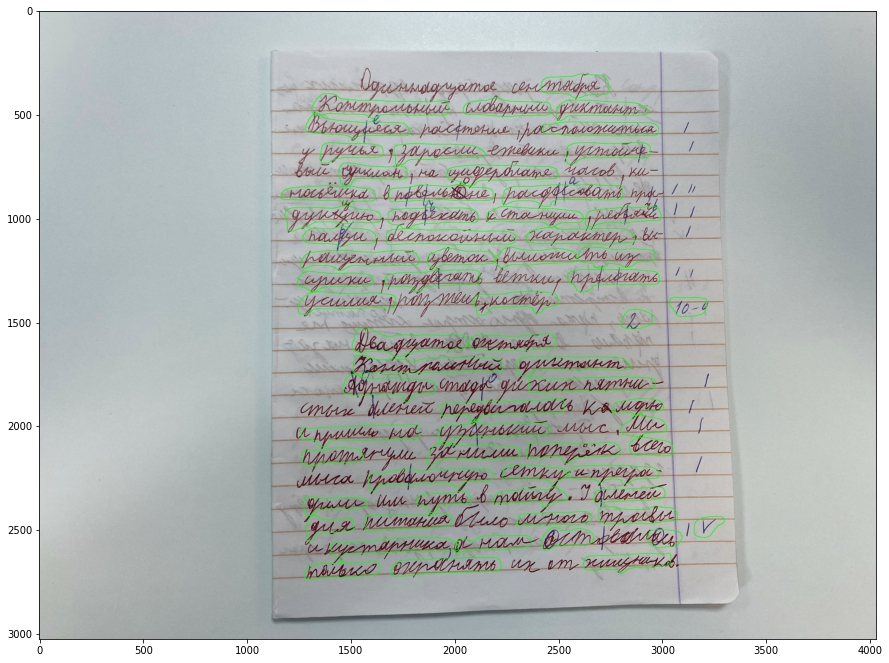

In [4]:
segm_predictor = SEGMpredictor(model_path='segm-model_final.pth')

img = cv2.imread('train_segmentation/images/100_0.JPG')
contours = segm_predictor(img)

for contour in contours:
    cv2.drawContours(img, np.array([contour]), -1, (0, 255, 0), 2)

plt.figure(figsize=(15, 15))
plt.imshow(img)
plt.show()

# 2. Определяем модель OCR для инференса

Модель распознавания текста работает точно так же, как в бейзлайне второго этапа олимпиады (распознавание). 

Только если во втором этапе модель принимала на вход заранее вырезанные из целой фотографии элементы текста и переводила их (весь датасет состоял из пар вырезанного по маске текста и соответствующего перевода). Сейчас же мы используем эту модель в рамках общей системы распознавания. И теперь для перевода она принимает вырезанные с помощью предыдущей модели сегментации изображения текста.

Но в этом разделе (2) мы просто подгружаем модель и инициализируем основные функции для инференса.

### 2.1. Токенайзер - вспопогательный класс, который преобразует текст в числа

Для преобразоввания числовоого предсказания модели обратно в текст.

In [5]:
OOV_TOKEN = '<OOV>'
CTC_BLANK = '<BLANK>'


def get_char_map(alphabet):
    """Make from string alphabet character2int dict.
    Add BLANK char fro CTC loss and OOV char for out of vocabulary symbols."""
    char_map = {value: idx + 2 for (idx, value) in enumerate(alphabet)}
    char_map[CTC_BLANK] = 0
    char_map[OOV_TOKEN] = 1
    return char_map


class Tokenizer:
    """Class for encoding and decoding string word to sequence of int
    (and vice versa) using alphabet."""

    def __init__(self, alphabet):
        self.char_map = get_char_map(alphabet)
        self.rev_char_map = {val: key for key, val in self.char_map.items()}

    def encode(self, word_list):
        """Returns a list of encoded words (int)."""
        enc_words = []
        for word in word_list:
            enc_words.append(
                [self.char_map[char] if char in self.char_map
                 else self.char_map[OOV_TOKEN]
                 for char in word]
            )
        return enc_words

    def get_num_chars(self):
        return len(self.char_map)

    def decode(self, enc_word_list):
        """Returns a list of words (str) after removing blanks and collapsing
        repeating characters. Also skip out of vocabulary token."""
        dec_words = []
        for word in enc_word_list:
            word_chars = ''
            for idx, char_enc in enumerate(word):
                # skip if blank symbol, oov token or repeated characters
                if (
                    char_enc != self.char_map[OOV_TOKEN]
                    and char_enc != self.char_map[CTC_BLANK]
                    # idx > 0 to avoid selecting [-1] item
                    and not (idx > 0 and char_enc == word[idx - 1])
                ):
                    word_chars += self.rev_char_map[char_enc]
            dec_words.append(word_chars)
        return dec_words

### 2.2. Базовые трансформы модели

Здесь мы задаем базовые трансформы для инференса OCR

In [6]:
class Normalize:
    def __call__(self, img):
        img = img.astype(np.float32) / 255
        return img


class ToTensor:
    def __call__(self, arr):
        arr = torch.from_numpy(arr)
        return arr


class MoveChannels:
    """Move the channel axis to the zero position as required in pytorch."""

    def __init__(self, to_channels_first=True):
        self.to_channels_first = to_channels_first

    def __call__(self, image):
        if self.to_channels_first:
            return np.moveaxis(image, -1, 0)
        else:
            return np.moveaxis(image, 0, -1)


class ImageResize:
    def __init__(self, height, width):
        self.height = height
        self.width = width

    def __call__(self, image):
        image = cv2.resize(image, (self.width, self.height),
                           interpolation=cv2.INTER_LINEAR)
        return image


def get_val_transforms(height, width):
    transforms = torchvision.transforms.Compose([
        ImageResize(height, width),
        MoveChannels(to_channels_first=True),
        Normalize(),
        ToTensor()
    ])
    return transforms

### 2.3. Здесь определяем саму модель - CRNN

Подробнее об архитектуре можно почитать в статье https://arxiv.org/abs/1507.05717

In [7]:
def get_resnet34_backbone(pretrained=True):
    m = torchvision.models.resnet34(pretrained=True)
    input_conv = nn.Conv2d(3, 64, 7, 1, 3)
    blocks = [input_conv, m.bn1, m.relu,
              m.maxpool, m.layer1, m.layer2, m.layer3]
    return nn.Sequential(*blocks)


class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers,
            dropout=dropout, batch_first=True, bidirectional=True)

    def forward(self, x):
        out, _ = self.lstm(x)
        return out


class CRNN(nn.Module):
    def __init__(
        self, number_class_symbols, time_feature_count=256, lstm_hidden=256,
        lstm_len=2,
    ):
        super().__init__()
        self.feature_extractor = get_resnet34_backbone(pretrained=True)
        self.avg_pool = nn.AdaptiveAvgPool2d(
            (time_feature_count, time_feature_count))
        self.bilstm = BiLSTM(time_feature_count, lstm_hidden, lstm_len)
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden * 2, time_feature_count),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(time_feature_count, number_class_symbols)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        b, c, h, w = x.size()
        x = x.view(b, c * h, w)
        x = self.avg_pool(x)
        x = x.transpose(1, 2)
        x = self.bilstm(x)
        x = self.classifier(x)
        x = nn.functional.log_softmax(x, dim=2).permute(1, 0, 2)
        return x

### 2.4. Определяем класс для использования OCR-модели на инференсе

In [8]:
def predict(images, model, tokenizer, device):
    model.eval()
    images = images.to(device)
    with torch.no_grad():
        output = model(images)
    pred = torch.argmax(output.detach().cpu(), -1).permute(1, 0).numpy()
    text_preds = tokenizer.decode(pred)
    return text_preds


class InferenceTransform:
    def __init__(self, height, width):
        self.transforms = get_val_transforms(height, width)

    def __call__(self, images):
        transformed_images = []
        for image in images:
            image = self.transforms(image)
            transformed_images.append(image)
        transformed_tensor = torch.stack(transformed_images, 0)
        return transformed_tensor


class OcrPredictor:
    def __init__(self, model_path, config, device='cuda'):
        self.tokenizer = Tokenizer(config['alphabet'])
        self.device = torch.device(device)
        # load model
        self.model = CRNN(number_class_symbols=self.tokenizer.get_num_chars())
        self.model.load_state_dict(torch.load(model_path))
        self.model.to(self.device)

        self.transforms = InferenceTransform(
            height=config['image']['height'],
            width=config['image']['width'],
        )

    def __call__(self, images):
        if isinstance(images, (list, tuple)):
            one_image = False
        elif isinstance(images, np.ndarray):
            images = [images]
            one_image = True
        else:
            raise Exception(f"Input must contain np.ndarray, "
                            f"tuple or list, found {type(images)}.")

        images = self.transforms(images)
        pred = predict(images, self.model, self.tokenizer, self.device)

        if one_image:
            return pred[0]
        else:
            return pred

### Применим модель

In [10]:
# Конфиг для модели OCR

config_json = {
    "alphabet": ''' !"%\'()*+,-./0123456789:;<=>?ABCDEFGHIJKLMNOPRSTUVWXY[]_abcdefghijklmnopqrstuvwxyz|}ЁАБВГДЕЖЗИКЛМНОПРСТУФХЦЧШЩЫЬЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё№''',
    "image": {
        "width": 256,
        "height": 32
    }
}

диктант


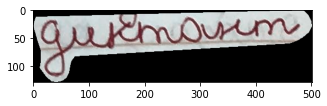

In [11]:
ocr_predictor = OcrPredictor(
    model_path='ocr-model-last.ckpt',
    config=config_json
)

img = cv2.imread('train_recognition/images/50038.png')
pred_text = ocr_predictor(img)

print(pred_text)
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.show()

# 3. Объединяем сегментацию и OCR в единый пайплайн


Напишем класс PiepleinePredictor для использования моделей сегментации и OCR в одном пайпайне. Модель OCR будет предсказыать текст на картинках, вырезанных по полигонам, которые предсказала модель сегментации.

In [12]:
def get_image_visualization(img, pred_data, fontpath, font_koef=50):
    h, w = img.shape[:2]
    font = ImageFont.truetype(fontpath, int(h/font_koef))
    empty_img = Image.new('RGB', (w, h), (255, 255, 255))
    draw = ImageDraw.Draw(empty_img)

    for prediction in pred_data['predictions']:
        polygon = prediction['polygon']
        pred_text = prediction['text']
        cv2.drawContours(img, np.array([polygon]), -1, (0, 255, 0), 2)
        x, y, w, h = cv2.boundingRect(np.array([polygon]))
        draw.text((x, y), pred_text, fill=0, font=font)

    vis_img = np.array(empty_img)
    vis = np.concatenate((img, vis_img), axis=1)
    return vis


def crop_img_by_polygon(img, polygon):
    # https://stackoverflow.com/questions/48301186/cropping-concave-polygon-from-image-using-opencv-python
    pts = np.array(polygon)
    rect = cv2.boundingRect(pts)
    x,y,w,h = rect
    croped = img[y:y+h, x:x+w].copy()
    pts = pts - pts.min(axis=0)
    mask = np.zeros(croped.shape[:2], np.uint8)
    cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)
    dst = cv2.bitwise_and(croped, croped, mask=mask)
    return dst


class PiepleinePredictor:
    def __init__(self, segm_model_path, ocr_model_path, ocr_config):
        self.segm_predictor = SEGMpredictor(model_path=segm_model_path)
        self.ocr_predictor = OcrPredictor(
            model_path=ocr_model_path,
            config=config_json
        )

    def __call__(self, img):
        output = {'predictions': []}
        contours = self.segm_predictor(img)
        for contour in contours:
            if contour is not None:
                crop = crop_img_by_polygon(img, contour)
                pred_text = self.ocr_predictor(crop)
                output['predictions'].append(
                    {
                        'polygon': [[int(i[0][0]), int(i[0][1])] for i in contour],
                        'text': pred_text
                    }
                )
        return output

In [13]:
pipeline_predictor = PiepleinePredictor(
    segm_model_path='segm-model_final.pth',
    ocr_model_path='ocr-model-last.ckpt',
    ocr_config=config_json
)

#### Визуализируме предсказания пайплайна

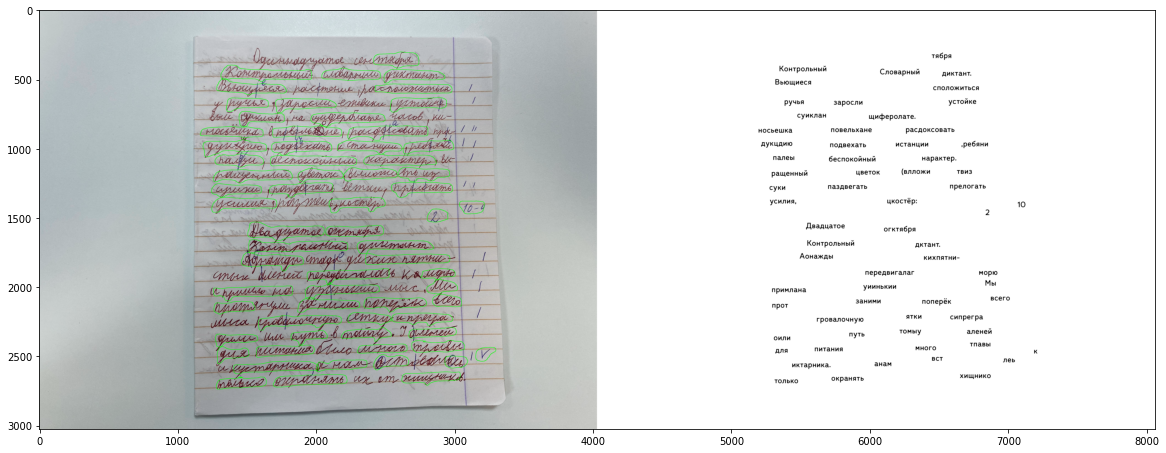

In [14]:
img = cv2.imread('train_segmentation/images/100_0.JPG')
output = pipeline_predictor(img)

vis = get_image_visualization(img, output, 'font.otf')

plt.figure(figsize=(20, 20))
plt.imshow(vis)
plt.show()

# 4. Сохраним предсказания для датасета

Пайплайн должен возвращать словарь формата json. Ключи - названия изображений, на которых сделаны предсказания. Значения - словарь с ключом `predictions`, его значения - список из словарей, который содержат координаты полигонов и распознанный текст. 

Формат словаря, который возвращает пайплайн:

```
{
"img_0.jpg": {
        "predictions": [
            {
                "polygon": [
                    [0, 0],
                    [0, 1],
                    [1, 0],
                    [1, 1]
                ],
                "text": "test"
            }
        ]
    }
    "img_1.jpg": {
    "predictions": [
    ...
    ]
    }
}
```

### Разделим датасет на трейн и вал

In [15]:
with open('train_segmentation/annotations.json', 'r') as f:
    annotations = json.load(f)


annotations_val = {}
annotations_val['categories'] = annotations['categories']

annotations_train = {}
annotations_train['categories'] = annotations['categories']


# Положим в валидацию каждое 10 изображение из исходного train, а остальные - в новый train
annotations_val['images'] = []
annotations_train['images'] = []
for num,img in enumerate(annotations['images']):
    if num%12 == 0:
        annotations_val['images'].append(img)
    else:
        annotations_train['images'].append(img)

# Положим в список аннотаций валидации только те аннотации, которые относятся к изображениям из валидации. 
# А в список аннотаций нового train - только те, которые относятся к нему
val_img_id = [i['id'] for i in annotations_val['images']]
train_img_id = [i['id'] for i in annotations_train['images']]

annotations_val['annotations'] = []
annotations_train['annotations'] = []

for annot in annotations['annotations']:
    if annot['image_id'] in val_img_id:
        annotations_val['annotations'].append(annot)
    elif annot['image_id'] in train_img_id:
        annotations_train['annotations'].append(annot)
    else:
        print('Аннотации нет ни в одном наборе')
    

# Сохраим json'ы
with open('train_segmentation/annotations_val.json', 'w') as outfile:
    json.dump(annotations_val, outfile)
    
    
with open('train_segmentation/annotations_train.json', 'w') as outfile:
    json.dump(annotations_train, outfile)

### Зададим пути к датасету

In [15]:
# Путь к json'у с разметкой
DATA_JSON_PATH = 'train_segmentation/annotations_val.json'

# Папка с картинками тетрадей
IMAGE_ROOT = 'train_segmentation/images/'

# Файл для сохранения предсказаний пайплайна. Один json
SAVE_PATH = 'prediction.json'

In [16]:
with open(DATA_JSON_PATH, 'r') as f:
    data = json.load(f)

pred_data = {}

In [17]:
for data_img in tqdm(data['images']):
    img_name = data_img['file_name']
    image = cv2.imread(os.path.join(IMAGE_ROOT, img_name))
    pred_data[img_name] = pipeline_predictor(image)

100%|██████████| 78/78 [02:38<00:00,  2.03s/it]


In [18]:
with open(SAVE_PATH, "w") as f:
    json.dump(pred_data, f)

# 5. Оценка точности пайплайна

Скрипт evaluate.py определяет метрику для оценки пайплайна. Фактически это просто расчет accuracy и CER для OCR-модели из пайплайна.

Однако теперь мы предсказываем текст на картинках, вырезанных по предсказанным полигонам. И чтобы понять, с каким ground truth текстом нужно сравнивать предсказанный текст, нужно сматчить предсказанные полигоны с ground truth полигонами.

Скрипт evaluate.py для каждого gt-полигона из тетради ищет соответствующий ему предсказанный полигон. Выбираем из предсказанных полигонов тот, который имеет наибольшее пересечение по IoU с gt-полигоном (при этом IoU должно быть больше нуля). Таким образом матчим gt-текст из данного полигона с предсказанным текстом. Это true positive предсказания.

False negative случаи - если для gt-полигона не был сопоставлен предсказанный полигон, то предсказанный текст для такого полигона устанавливается как пустой "" (т.к. пайплайн не предсказал текст там, где он должен быть).

Для всех false positive предсказанных полигонов (т.е. тех, для которых отсутствуют gt-полигоны) gt-текст устанавливается как пустой "" (т.к. пайплайн предсказал текст там, где его нет)

In [20]:
import time

In [21]:
start = time.time()
!python3 evaluate.py --ref_path train_segmentation/annotations_val.json --pred_path prediction.json
end = time.time()
print(end-start)

{'CER': 0.7513511010632274}
18.047777891159058
